In [4]:
import numpy as np
import torch
import pickle
import csv
import os

import random
# -----------
seed = 1337
# Set seeds
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# Own libraries
import utils
import trainer as trainer
import model_channel as model
import model_turboAE as model_TAE
import model_prodAE as model_prodAE

import gc
gc.collect()
torch.cuda.empty_cache()

## Encoding parameters

k = 64 and n = 128 for rate 0.5. This will yield the same result in SNR and EBN0 and is good for comparison.

In [2]:
k = 100 # msg length in bits
n = 200 # codeword length
bs = 500  # batch size

rate = (k/n)
TRAINING_SNR = 2

#noise_std = utils.SNR_to_noise(TRAINING_SNR)
noise_std = utils.EbNo_to_noise(TRAINING_SNR, rate)

print("Code rate: ",rate)

Code rate:  0.5


## Create path for data

In [3]:
from datetime import datetime
# Get the current date and time
now = datetime.now()
# Format the date and time
formatted_date = now.strftime("%Y%m%d_%H%M%S")
# Construct the model's filename
path = f"./data/Binary_run_{formatted_date}.pth"

folder_path = './data/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"'{folder_path}' has been created.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Turboe AE

- Normal Interleaver is model_TAE.Interleaver(config)
- Interleaver with backprop route is "model_TAE.LearnableInterleaver(config)"
- Gumbel interleaver is experimental for having a "learnable soft permutation".

In [4]:
### Turbo AE
config = model_TAE.TurboConfig(block_len=k, enc_num_unit=100, dec_num_unit=100)

## Gumbel Interleaver: 

#import random
#perm = list(range(config.block_len))
#random.shuffle(perm)
#interleaver = model_TAE.GumbelInterleaver(config, permutation=perm)

## Normal interleaver:

#interleaver = model_TAE.LearnableInterleaver(config)
interleaver = model_TAE.Interleaver(config)

encoder = model_TAE.ENC_CNNTurbo(config, interleaver).to(device)
decoder = model_TAE.DEC_CNNTurbo(config, interleaver).to(device)

Array:  [26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76 60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40
 38  5 91 59  0 34 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29
 49 97 98 69 20 94 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96
 67 64 47 44]


In [5]:
#encoder = model_CNNENC.Encoder().to(device)
#decoder = model_CNNENC.Decoder().to(device)

In [6]:
#encoder = model_t.TransformerEncoder(input_dim=k, num_symbols=2, d_model=64, nhead=8, num_layers=2, dim_feedforward=256, output_dim=n).to(device)
#decoder = model_t.TransformerDecoder(input_dim=n, d_model=64, nhead=8, num_layers=1, dim_feedforward=256, output_dim=k).to(device)

## Product AE

Implementation of the product AE paper. The code is (K_1 x K_2, N_1 x N_2) long 

In [7]:
# Encoding parameters
#K = [8, 8]
#N = [8, 16]

#rate = (K[0]/N[0])*(K[1]/N[1])
#I = 4

#encoder = model_prodAE.ProductAEEncoder(K, N).to(device)
#decoder = model_prodAE.ProdDecoder(I, K, N).to(device)

## Load Checkpoints if necessary

In [8]:
#checkpoint = torch.load('./data/Binary_run_x.pth')
#encoder.load_state_dict(checkpoint['encoder_state_dict'])
#decoder.load_state_dict(checkpoint['decoder_state_dict'])

<All keys matched successfully>

In [9]:
channel = model.Channel_AWGN().to(device)

train_loss = []
print(encoder)
print(decoder)
combined_params = list(encoder.parameters()) + list(decoder.parameters())
print("parameters: ",sum(p.numel() for p in combined_params))
print("trainable: ",sum(p.numel() for p in combined_params if p.requires_grad))

it = int(5e4/bs) # 5e4 blocks // 500 bs iterations times 6 alternate epochs was TurboAE specs


conf = trainer.TrainerConfig(max_epochs=300, noise_std = noise_std, training_snr = TRAINING_SNR, rate=rate, path=path, batchsize=bs, coderate=k, learning_rate=1e-4, iterations=it, optimizer='Adam')
t = trainer.Trainer(encoder, decoder, channel, conf)
train_loss = t.train_alternate()



path_loss = f"{folder_path}train_loss_{formatted_date}.pth"
with open(path_loss, 'wb') as f:
        pickle.dump(train_loss, f)

ENC_CNNTurbo(
  (interleaver): Interleaver()
  (enc_cnn_1): Sequential(
    (0): ModuleLambda()
    (1): Conv1d(1, 100, kernel_size=(25,), stride=(1,), padding=(12,))
    (2): LayerNorm((100, 100), eps=1e-05, elementwise_affine=True)
    (3): ModuleLambda()
    (4): Conv1d(100, 100, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): LayerNorm((100, 100), eps=1e-05, elementwise_affine=True)
    (6): ModuleLambda()
    (7): ModuleLambda()
  )
  (enc_cnn_2): Sequential(
    (0): ModuleLambda()
    (1): Conv1d(1, 100, kernel_size=(25,), stride=(1,), padding=(12,))
    (2): LayerNorm((100, 100), eps=1e-05, elementwise_affine=True)
    (3): ModuleLambda()
    (4): Conv1d(100, 100, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): LayerNorm((100, 100), eps=1e-05, elementwise_affine=True)
    (6): ModuleLambda()
    (7): ModuleLambda()
  )
  (enc_linear_1): Linear(in_features=100, out_features=1, bias=True)
  (enc_linear_2): Linear(in_features=100, out_features=1, bias=True)
)
DEC_C

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.156e-01 BER 3.990e-02 SER 9.828e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.127e-01 BER 3.963e-02 SER 9.824e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.139e-01 BER 3.963e-02 SER 9.805e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.145e-01 BER 3.948e-02 SER 9.815e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.120e-01 BER 3.920e-02 SER 9.822e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.140e-01 BER 3.906e-02 SER 9.805e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.125e-01 BER 3.893e-02 SER 9.809e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.132e-01 BER 3.901e-02 SER 9.808e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.121e-01 BER 3.886e-02 SER 9.803e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.148e-01 BER 3.917e-02 SER 9.799e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.137e-01 BER 3.887e-02 SER 9.803e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

------------------
(Validation) : loss 1.125e-01 BER 3.891e-02 SER 9.803e-01
------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

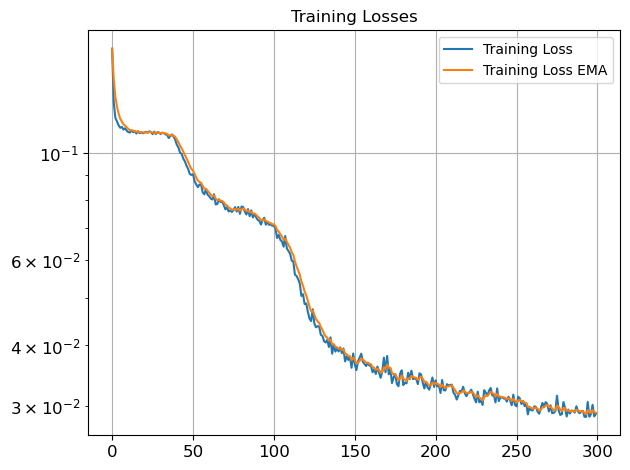

In [5]:
with open('./data/train_loss_20231026_140800.pth', 'rb') as f:
    train_loss = pickle.load(f)
utils.plot_train_loss(train_loss)

## Test run

In [ ]:
checkpoint = torch.load('./data/Binary_run_20231026_140800.pth')
#checkpoint = torch.load('./Binary_run_xx.pth')
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

In [ ]:
import importlib
import trainer as trainer
importlib.reload(trainer)


bler, ser, ber = [], [], []
snr_range = [3,4,4.5,5]
ber, ser, bler = t.test(snr_range=snr_range, rate=rate, iterations=1e3)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(snr_range, ber, marker='o', linestyle='-', label='BER')
plt.plot(snr_range, bler, marker='o', linestyle='-', label='BLER')
plt.xlabel('EbN0 (dB)')
plt.ylabel('Error Value')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig('ber_bler.png', dpi=300)
plt.show()

## Benchmark results from the vanilla TurboAE code over 400 Epochs with rate=0.5

parameters: encoder='TurboAE_rate2_cnn', decoder='TurboAE_rate2_cnn', channel='awgn', vv=5, radar_prob=0.05, radar_power=5.0, bec_p=0.0, bsc_p=0.0, bec_p_dec=0.0, bsc_p_dec=0.0, train_enc_channel_low=2.0, train_enc_channel_high=2.0, train_dec_channel_low=-1.5, train_dec_channel_high=2.0, init_nw_weight='default', code_rate_k=1, code_rate_n=2, enc_rnn='gru', dec_rnn='gru', num_iteration=6, extrinsic=1, num_iter_ft=5, is_interleave=1, is_same_interleaver=1, is_parallel=1, enc_kernel_size=5, dec_kernel_size=5, enc_num_layer=2, dec_num_layer=5, dec_num_unit=100, enc_num_unit=100, enc_act='elu', dec_act='linear', num_ber_puncture=5, joint_train=0, num_train_dec=5, num_train_enc=1, dropout=0.0, snr_test_start=-1.5, snr_test_end=4.0, snr_points=12, batch_size=500, num_epoch=100, test_ratio=1, block_len=100, block_len_low=10, block_len_high=200, is_variable_block_len=False, img_size=10, num_block=50000, test_channel_mode='block_norm', train_channel_mode='block_norm', enc_truncate_limit=0, mod_rate=2, mod_num_layer=1, mod_num_unit=20, demod_num_layer=1, demod_num_unit=20, mod_lr=0.005, demod_lr=0.005, num_train_mod=1, num_train_demod=5, mod_pc='block_power', no_code_norm=False, enc_quantize_level=2, enc_value_limit=1.0, enc_grad_limit=0.01, enc_clipping='both', optimizer='adam', dec_lr=0.0001, enc_lr=0.0001, momentum=0.9, loss='bce', ber_lambda=1.0, bce_lambda=1.0, focal_gamma=0.0, focal_alpha=1.0, lambda_maxBCE=0.01, no_cuda=False, rec_quantize=False, rec_quantize_level=2, rec_quantize_limit=1.0, print_pos_ber=False, print_pos_power=False, print_test_traj=True, precompute_norm_stats=False, is_k_same_code=False, k_same_code=2)

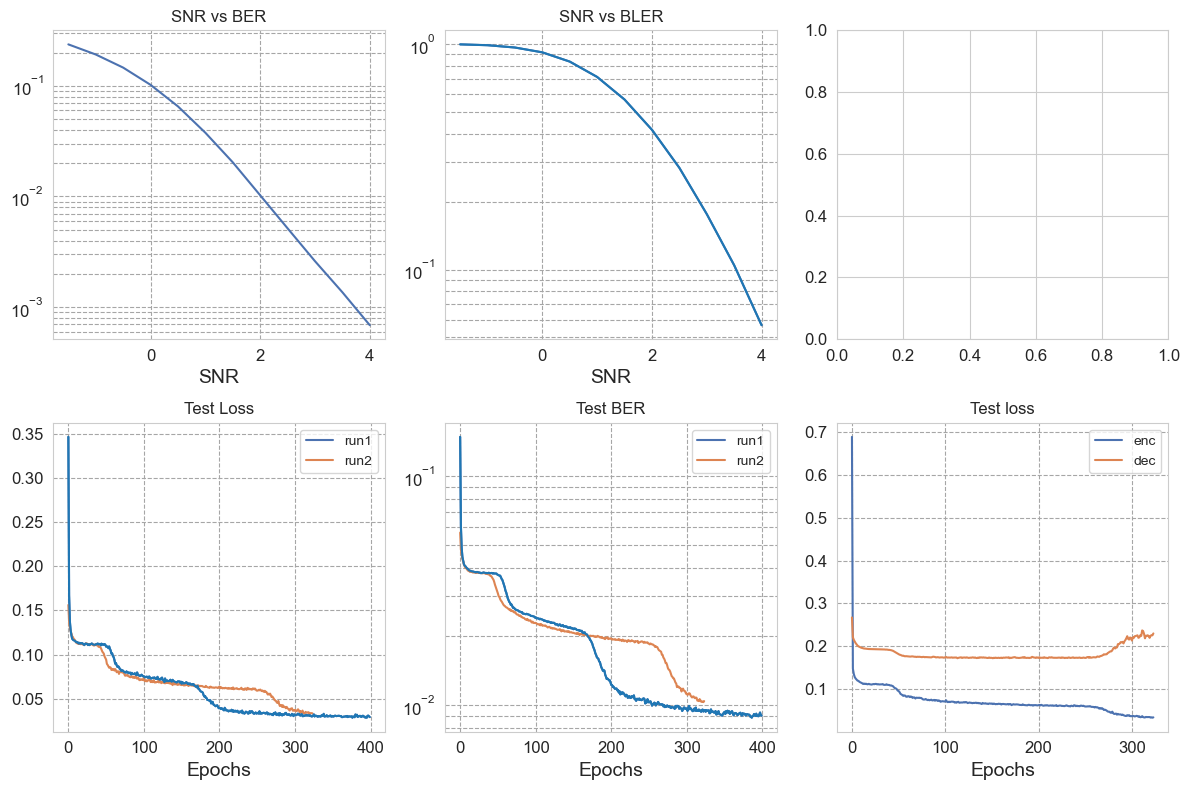

In [6]:
import plot_benchmark_turboAE_vanilla as plot_benchmark
plot_benchmark.plot()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
utils.print_memory()